In [1]:
# from VariationalBayes import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
# from VariationalBayes.NormalParams import MVNParam, UVNParam, UVNParamVector
# from VariationalBayes.GammaParams import GammaParam
# from VariationalBayes.ExponentialFamilies import \
#     univariate_normal_entropy, multivariate_normal_entropy, gamma_entropy, \
#     mvn_prior, uvn_prior, gamma_prior

import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, SparseObjective

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from autograd import jacobian
# import autograd.numpy as np
# import autograd.numpy.random as npr
# import autograd.scipy as sp
# import scipy as osp

import copy
from scipy import optimize

In [26]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

simulate_data = False
prior_par = vb.ModelParamsDict('Prior Parameters')

if not simulate_data:
    #analysis_name = 'simulated_data_small'
    #analysis_name = 'simulated_data_large'
    analysis_name = 'criteo_subsampled'

    data_dir = os.path.join(os.environ['GIT_REPO_LOC'], 'LRVBLogitGLMM/LogitGLMMLRVB/inst/data/')
    json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
    json_output_filename = os.path.join(data_dir, '%s_python_vb_results.json' % analysis_name)

    json_file = open(json_filename, 'r')
    json_dat = json.load(json_file)
    json_file.close()

    stan_dat = json_dat['stan_dat']
    vp_base = json_dat['vp_base']

    print stan_dat.keys()
    K = stan_dat['K'][0]
    NObs = stan_dat['N'][0]
    NG = stan_dat['NG'][0]
    #N = NObs / NG
    y_g_vec = np.array(stan_dat['y_group'])
    y_vec = np.array(stan_dat['y'])
    x_mat = np.array(stan_dat['x'])
    
    # Define a class to contain prior parameters.
    prior_par.push_param(vb.VectorParam('beta_prior_mean', K, val=np.array(stan_dat['beta_prior_mean'])))
    beta_prior_info = np.linalg.inv(np.array(stan_dat['beta_prior_var']))
    prior_par.push_param(vb.PosDefMatrixParam('beta_prior_info', K, val=beta_prior_info))

    prior_par.push_param(vb.ScalarParam('mu_prior_mean', val=stan_dat['mu_prior_mean'][0]))
    prior_par.push_param(vb.ScalarParam('mu_prior_info', val=1 / stan_dat['mu_prior_var'][0]))

    prior_par.push_param(vb.ScalarParam('tau_prior_alpha', val=stan_dat['tau_prior_alpha'][0]))
    prior_par.push_param(vb.ScalarParam('tau_prior_beta', val=stan_dat['tau_prior_beta'][0]))

    # An index set to make sure jacobians match the order expected by R.
    prior_par_indices = copy.deepcopy(prior_par)
    prior_par_indices.set_name('Prior Indices')
    prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))
else:
    # Simulate data instead of loading it if you like
    N = 200     # observations per group
    K = 5      # dimension of regressors
    NG = 200      # number of groups

    # Generate data

    true_beta = np.array(range(5))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0

    x_mat, y_g_vec, y_vec, true_rho, true_u = \
        logit_glmm.simulate_data(N, NG, true_beta, true_mu, true_tau)

    prior_par.push_param(vb.VectorParam('beta_prior_mean', K, val=np.zeros(K)))
    prior_par.push_param(vb.PosDefMatrixParam('beta_prior_info', K, val=0.01 * np.eye(K)))

    prior_par.push_param(vb.ScalarParam('mu_prior_mean', val=0))
    prior_par.push_param(vb.ScalarParam('mu_prior_info', val=0.5))

    prior_par.push_param(vb.ScalarParam('tau_prior_alpha', val=3.0))
    prior_par.push_param(vb.ScalarParam('tau_prior_beta', val=10.0))

print np.mean(y_vec)

[u'y_group', u'mu_prior_var', u'mu_prior_t', u'mu_prior_var_c', u'K', u'beta_prior_var', u'tau_prior_beta', u'N', u'mu_prior_mean_c', u'mu_prior_epsilon', u'mu_prior_mean', u'y', u'x', u'NG', u'beta_prior_mean', u'tau_prior_alpha']
0.171046565237


In [27]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
glmm_par = vb.ModelParamsDict('GLMM Parameters')

glmm_par.push_param(vb.UVNParam('mu', min_info=vp_base['mu_info_min'][0]))
glmm_par.push_param(vb.GammaParam('tau',
                               min_shape=vp_base['tau_alpha_min'][0],
                               min_rate=vp_base['tau_beta_min'][0]))
glmm_par.push_param(vb.MVNParam('beta', K, min_info=vp_base['beta_diag_min'][0]))
glmm_par.push_param(vb.UVNParamVector('u', NG, min_info=vp_base['u_info_min'][0]))

advi_init = False
if advi_init:
    pass
# Initialize with ADVI.  Don't forget to add the ADVI computation time to your final VB time!
#     advi_fit = json_dat['advi_results']
#     glmm_par['mu'].mean.set(advi_fit['mu_mean'][0])
#     glmm_par['mu'].info.set(1 / advi_fit['mu_var'][0])

#     tau_mean = advi_fit['tau_mean'][0]
#     tau_var = advi_fit['tau_var'][0]
#     glmm_par['tau'].shape.set((tau_mean ** 2) / tau_var)
#     glmm_par['tau'].rate.set(tau_var / tau_mean)

#     glmm_par['beta'].mean.set(np.array(advi_fit['beta_mean']))
#     glmm_par['beta'].info.set(np.array(advi_fit['beta_info']))

#     glmm_par['u'].mean.set(np.array(advi_fit['u_mean']))
#     glmm_par['u'].info.set(1 / np.array(advi_fit['u_var']))

#     free_par_vec = glmm_par.get_free()
else:
    glmm_par['mu'].mean.set(0.0)
    glmm_par['mu'].info.set(1.0)

    glmm_par['tau'].shape.set(2.0)
    glmm_par['tau'].rate.set(2.0)

    glmm_par['beta'].mean.set(np.full(K, 0.0))
    glmm_par['beta'].info.set(np.eye(K))

    glmm_par['u'].mean.set(np.full(NG, 0.0))
    glmm_par['u'].info.set(np.full(NG, 1.0))

free_par_vec = glmm_par.get_free()
    

IndentationError: expected an indented block (<ipython-input-27-7e2e075b08ff>, line 30)

In [4]:
# Define moment parameters

moment_par = vb.ModelParamsDict('Moment Parameters')
moment_par.push_param(vb.VectorParam('e_beta', K))
moment_par.push_param(vb.PosDefMatrixParam('e_beta_outer', K))
moment_par.push_param(vb.ScalarParam('e_mu'))
moment_par.push_param(vb.ScalarParam('e_mu2'))
moment_par.push_param(vb.ScalarParam('e_tau'))
moment_par.push_param(vb.ScalarParam('e_log_tau'))
moment_par.push_param(vb.VectorParam('e_u', NG))
moment_par.push_param(vb.VectorParam('e_u2', NG))

def set_moments(glmm_par, moment_par):
    moment_par['e_beta'].set(glmm_par['beta'].e())
    moment_par['e_beta_outer'].set(glmm_par['beta'].e_outer())
    moment_par['e_mu'].set(glmm_par['mu'].e())
    moment_par['e_mu2'].set(glmm_par['mu'].e_outer())
    moment_par['e_tau'].set(glmm_par['tau'].e())
    moment_par['e_log_tau'].set(glmm_par['tau'].e_log())
    moment_par['e_u'].set(glmm_par['u'].e())
    moment_par['e_u2'].set((glmm_par['u'].e_outer()))
    
set_moments(glmm_par, moment_par)

# Moment indices.
moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(1 + np.array(range(moment_indices.vector_size())))

class MomentWrapper(object):
    def __init__(self, glmm_par, moment_par):
        self.__glmm_par_ad = copy.deepcopy(glmm_par)
        self.__moment_par = copy.deepcopy(moment_par)

    # Return a posterior moment of interest as a function of unconstrained parameters.
    def get_moments(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par.get_vector()
    
    def get_moment_parameters(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par

moment_wrapper = MomentWrapper(glmm_par, moment_par)
get_moment_jacobian = jacobian(moment_wrapper.get_moments)


Here's what we need to calculate for the random effect.  For a scalar quantity, $z \sim \mathcal{N}(\mu, \sigma^2)$, whose distribution is determined by the variational approximation and which is different for every observation, we need to calculate

$$
\mathbb{E}\left[\log\left(1 - \frac{\exp(z)}{1 + \exp(z)}\right)\right] = \\
\mathbb{E}\left[\log\left(\frac{1}{1 + \exp(z)}\right)\right] = \\
-\mathbb{E}\left[\log\left(1 + \exp(z)\right)\right]
$$

Given $n$ draws from a standard normal, $u$, we can approximate this expectation with

$$
\frac{1}{n} \sum_n \log\left(1 + \exp(\sigma s_n + \mu) \right)
$$

In [5]:

model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, 10)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()


objective = Objective(model.glmm_par, model.get_kl)
objective.fun_free(free_par_vec)

# # PriorHess evaluates the second order derivative d2 EPrior / dpar dprior_par
# PriorModelGrad = grad(kl_wrapper.ExpectedLogPrior, argnum=0)
# PriorHess = jacobian(PriorModelGrad, argnum=1)

# kl_wrapper.ExpectedLogPrior(free_par_vec, prior_par.get_vector())


array([ 25300.32307202])

In [6]:
import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: objective.fun_free(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: objective.fun_free_grad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: objective.fun_free_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num

Function time:
0.0274235963821
Grad time:
0.0664848089218
Hessian vector product time:
0.121609592438


In [7]:
glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, num_draws):
    model.set_draws(num_draws)
    vb_opt = optimize.minimize(
        lambda par: objective.fun_free(par, verbose=True),
        x0=trust_init,
        method='trust-ncg',
        jac=objective.fun_free_grad,
        hessp=objective.fun_free_hvp,
        tol=1e-6, options={'maxiter': 500, 'disp': True, 'gtol': 1e-6 })
    return vb_opt.x

def get_moment_vec(vb_opt_x):
    glmm_par_opt.set_free(vb_opt_x)
    set_moments(glmm_par_opt, moment_par)
    return moment_par.get_vector()


In [14]:
import time

init_par_vec = copy.deepcopy(free_par_vec)
objective.logger.initialize()

# Optimize.
num_mc_draws = 50

print 'Running Newton Trust Region'
vb_time = time.time()
opt_x = tr_optimize(init_par_vec, num_mc_draws)
vb_time = time.time() - vb_time

print 'Done.'

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(opt_x)
set_moments(glmm_par_opt, moment_par)

print vb_time / 60

Running Newton Trust Region
('Iter ', 74, ' value: ', array([ 27104.9130999]))
('Iter ', 75, ' value: ', array([ 19445.7923634]))
('Iter ', 76, ' value: ', array([ 11937.56162486]))
('Iter ', 77, ' value: ', array([ 8778.34570187]))
('Iter ', 78, ' value: ', array([ 7326.78748725]))
('Iter ', 79, ' value: ', array([ 6347.83589087]))
('Iter ', 80, ' value: ', array([ 5292.24551932]))
('Iter ', 81, ' value: ', array([ 4646.78724457]))
('Iter ', 82, ' value: ', array([ 4184.24965692]))
('Iter ', 83, ' value: ', array([ 2871.87627749]))
('Iter ', 84, ' value: ', array([ 1681.46338868]))
('Iter ', 85, ' value: ', array([ 824.00377353]))
('Iter ', 86, ' value: ', array([ 463.90996476]))
('Iter ', 87, ' value: ', array([-2800.23164255]))
('Iter ', 88, ' value: ', array([-3989.89812081]))
('Iter ', 89, ' value: ', array([-6724.36379076]))
('Iter ', 90, ' value: ', array([-7697.64254572]))
('Iter ', 91, ' value: ', array([-8815.30535638]))
('Iter ', 92, ' value: ', array([-9708.72828352]))
('It

In [9]:
if False:
    # Investigate the performance of different numbers of draws.   It doesn't appear to
    # converge.
    opt_x_20 = tr_optimize(init_par_vec, 20)
    opt_x_60 = tr_optimize(opt_x_20, 60)
    opt_x_100 = tr_optimize(opt_x_60, 100)
    opt_x_200 = tr_optimize(opt_x_100, 200)
    opt_x_400 = tr_optimize(opt_x_200, 400)
    opt_x_800 = tr_optimize(opt_x_400, 800)
    
    mom_20 = get_moment_vec(opt_x_20)
    mom_60 = get_moment_vec(opt_x_60)
    mom_100 = get_moment_vec(opt_x_100)
    mom_200 = get_moment_vec(opt_x_200)
    mom_400 = get_moment_vec(opt_x_400)
    mom_800 = get_moment_vec(opt_x_800)

    print np.max(np.abs((mom_20 - mom_60) / mom_20))
    print np.max(np.abs((mom_60 - mom_100) / mom_60))
    print np.max(np.abs((mom_100 - mom_200) / mom_100))
    print np.max(np.abs((mom_200 - mom_400) / mom_200))
    print np.max(np.abs((mom_400 - mom_800) / mom_400))

    print '-------\n'
    print np.max(np.abs((mom_20 - mom_60)))
    print np.max(np.abs((mom_60 - mom_100)))
    print np.max(np.abs((mom_100 - mom_200)))
    print np.max(np.abs((mom_200 - mom_400)))
    print np.max(np.abs((mom_400 - mom_800)))

    #diff_inds = np.where(np.abs(mom_60 - mom_100) > 1e-2)
    #print diff_inds
    #print moment_indices

    #print (get_moment_vec(opt_x_60) - get_moment_vec(opt_x_100)) / np.abs(get_moment_vec(opt_x_100))
    get_moment_vec(opt_x_200)
    u200 = copy.deepcopy(moment_par['e_u'].get())
    get_moment_vec(opt_x_400)
    u400 = copy.deepcopy(moment_par['e_u'].get())
    get_moment_vec(opt_x_800)
    u800 = copy.deepcopy(moment_par['e_u'].get())


-20954.820949
-20958.0387844
0.00209838052166
(array([  16,   20,   32,   62,   65,   68,   70,   90,  110,  115,  143,
        146,  165,  178,  184,  185,  195,  207,  212,  216,  219,  235,
        254,  273,  282,  295,  323,  342,  379,  406,  411,  417,  436,
        442,  479,  484,  490,  501,  505,  508,  523,  554,  575,  590,
        597,  598,  605,  608,  619,  622,  637,  639,  640,  643,  646,
        649,  650,  665,  679,  685,  692,  693,  713,  723,  736,  755,
        759,  808,  815,  837,  841,  848,  849,  853,  872,  874,  896,
        912,  919,  921,  927,  936,  937,  938,  951,  963,  967,  968,
        978,  979,  981,  989, 1007, 1008, 1024, 1040, 1041, 1042, 1055,
       1058, 1070, 1092, 1094, 1099, 1107, 1110, 1121, 1122, 1151, 1164,
       1173, 1179, 1192, 1200, 1218, 1225, 1231, 1240, 1245, 1248, 1258,
       1259, 1273, 1274, 1283, 1300, 1313, 1316, 1319, 1340, 1345, 1361,
       1388, 1402, 1410, 1415, 1431, 1444, 1469, 1471, 1479, 1485, 1504,
    

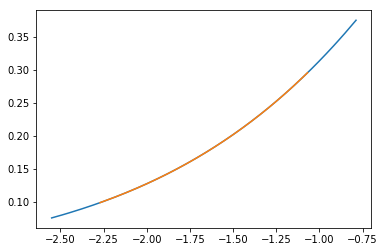

In [13]:
# Examine why the means are different for different number of simulations.
def get_logit_terms(num_draws):
    model.set_draws(num_draws)
    std_draws = model.std_draws

    e_beta = glmm_par_opt['beta'].mean.get()
    info_beta = glmm_par_opt['beta'].info.get()
    cov_beta = np.linalg.inv(info_beta)

    e_u = glmm_par_opt['u'].mean.get()[y_g_vec]
    info_u = glmm_par_opt['u'].info.get()[y_g_vec]
    var_u = 1 / info_u

    z_mean = e_u + np.matmul(x_mat, e_beta)
    z_sd = np.sqrt(var_u + np.einsum('nk,kj,nj->n', x_mat, cov_beta, x_mat))
    z = np.einsum('i,j->ij', z_sd, std_draws) + np.expand_dims(z_mean, 1)

    # The sum is over observations and draws, so dividing by the draws size
    # gives the sum of sample expectations over the draws.
    # p = exp(z) / (1 + exp(z))
    # log(1 - p) = log(1 / (1 + exp(z))) = -log(1 + exp(z))
    logit_terms = np.log1p(np.exp(z))
    logit_term = -np.sum(logit_terms) / std_draws.size

    return logit_term, logit_terms, z
    
logit_term_50, logit_terms_50, z_50 = get_logit_terms(50)    
logit_term_800, logit_terms_800, z_800 = get_logit_terms(800)

print logit_term_50
print logit_term_800

logit_terms_50_mean = np.mean(logit_terms_50, 1)
logit_terms_800_mean = np.mean(logit_terms_800, 1)

print np.max(np.abs(logit_terms_50_mean - logit_terms_800_mean))
print np.where(np.abs(logit_terms_50_mean - logit_terms_800_mean) > 1e-3)

ind = 3
plt.plot(z_800[ind, :], logit_terms_800[ind, :])
plt.plot(z_50[ind, :], logit_terms_50[ind, :])
print logit_terms_50_mean[ind]
print logit_terms_800_mean[ind]


In [ ]:
# Get the Hessians at the number of draws used for optimization.

model.set_draws(num_mc_draws)

hess_time = time.time()
print 'KL Hessian:\n'
kl_hess = objective.fun_free_hessian(opt_x)

print 'Log prior Hessian:\n'
log_prior_hess = PriorHess(opt_x, prior_par.get_vector())

hess_time =  time.time() - hess_time
elbo_hess = -kl_hess

print 'hess_time: %f' % hess_time

In [ ]:
moment_jac = MomentJacobian(opt_x)
lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

vp_indices = copy.deepcopy(glmm_par_opt)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))

In [ ]:
if not simulate_data:
    # Write the result to a JSON file for use in R.
    
    run_name = 'production'
    result_dict = { 'glmm_par_opt': glmm_par_opt.dictval(), 'run_name': run_name,
                    'vb_time': vb_time, 'hess_time': hess_time, 'num_mc_draws': num_mc_draws, 
                    'moment_indices': moment_indices.dictval(),
                    'prior_indices': prior_indices.dictval(),
                    'vp_indices': vp_indices.dictval(),
                    'lrvb_cov': lrvb_cov.tolist(), 'moment_jac': moment_jac.tolist(),
                    'elbo_hess': elbo_hess.tolist(), 'log_prior_hess': log_prior_hess.tolist() }

    result_json = json.dumps(result_dict)
    json_file = open(json_output_filename, 'w')
    json_file.write(result_json)
    json_file.close()

    print(json_output_filename)